## Neural Network Approach for Seasonal Items Forecasting of a Retail Store
## Double exponential smoothing, Triple exponential smoothing

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

## Load Dataset

In [2]:
data= pd.read_excel('../data/MRP_data.xls')

## Edit columns names

In [3]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [4]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales data by date

In [5]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [6]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

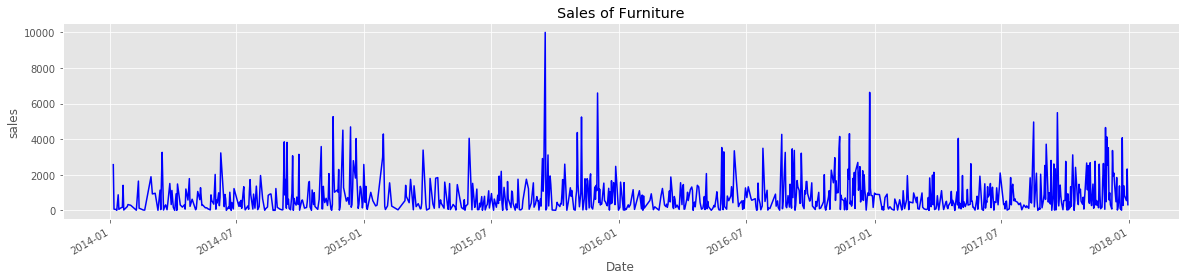

In [7]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furniture")
plt.show()

In [8]:
#Resampling the data on monthly frequency
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()
#df= df.to_frame() 

#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

In [9]:
df.head(n=5)

order_date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049187
Freq: MS, Name: sales, dtype: float64

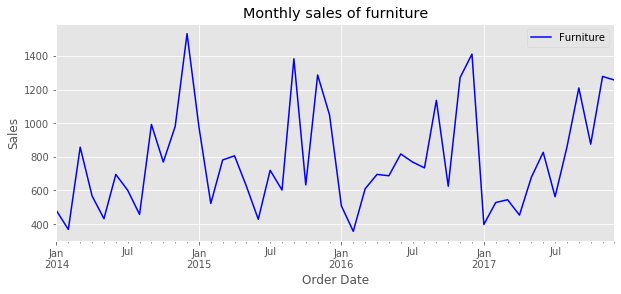

In [10]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

In [11]:
def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std() 
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])

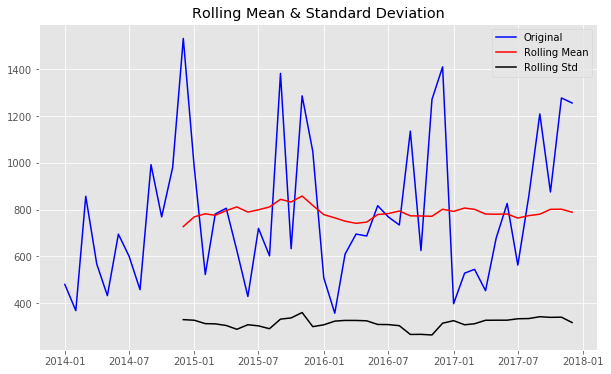

Results of Dickey-Fuller Test:
p-value= 9.168756655665942e-06


In [12]:
#check to see if the time-series is stationary or non-stationary
test_stationarity(df)
#p-value= 9.168756655665942e-06

### Train and test split

In [13]:
X = df
train_size = int(len(X) * 0.75)
trainset, testset= X[0:train_size], X[train_size:]

### Measure of prediction accuracy

In [14]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

## Double exponential smoothing

In [15]:
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing

DES = ExponentialSmoothing(trainset, trend = 'add')
DES_fit = DES.fit(smoothing_level=0.5)
DES_predict = DES_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'))

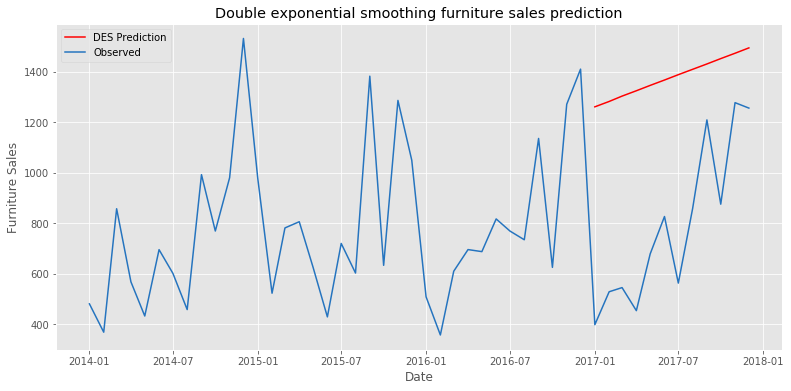

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
yhat_DES = DES_predict.values.tolist()
y = df.values.tolist()
plt.plot(DES_predict.index, yhat_DES, color='r',label='DES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Double exponential smoothing furniture sales prediction')
plt.show()

In [17]:
DES_results=performance(df[-12:], yhat_DES)
DES_results

{'MSE': 404594.09, 'RMSE': 636.08, 'MAPE': 98.79}

## Triple exponential smoothing

In [18]:
#Prediction with exponential smoothing + seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing
TES = ExponentialSmoothing(trainset, trend = 'add', seasonal = 'add', seasonal_periods = 12)
TES_fit = TES.fit(smoothing_level=0.5)
TES_predict = TES_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'))

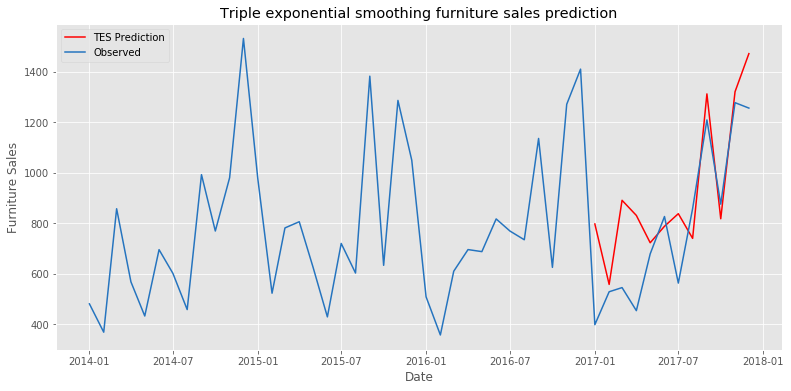

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Triple exponential smoothing furniture sales prediction')
plt.show()

In [20]:
TES_results= performance(df[-12:], yhat_TES)
TES_results

{'MSE': 48169.59, 'RMSE': 219.48, 'MAPE': 30.19}

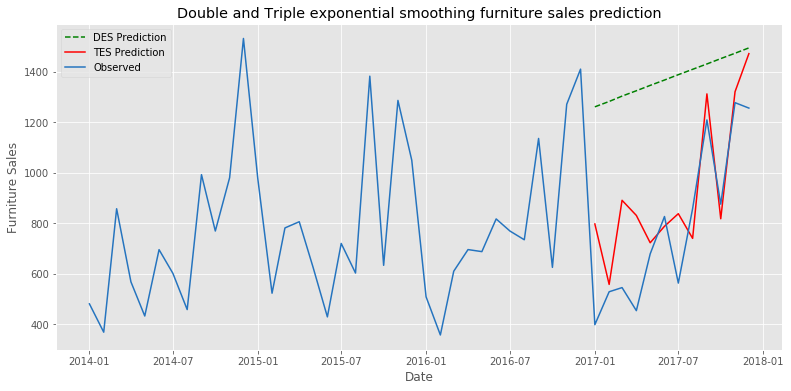

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.plot(DES_predict.index, yhat_DES, color='g',linestyle= "--",label='DES Prediction')
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Double and Triple exponential smoothing furniture sales prediction')
plt.show()